In [184]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [185]:
def load_model(target_var, model_dir='../models'):
    """Load model and scaler from file"""
    if 'memory' in target_var.lower():
        model_path = os.path.join(model_dir, 'xgb_memory_model.pkl')
        scaler_path = os.path.join(model_dir, 'xgb_memory_scaler.pkl')
    elif 'cpu' in target_var.lower():
        model_path = os.path.join(model_dir, 'xgb_cpu_model.pkl')
        scaler_path = os.path.join(model_dir, 'xgb_cpu_scaler.pkl')
    else:
        print(f"Error: Unknown target variable '{target_var}'")
        return None, None
    
    try:
        model = joblib.load(model_path)
        print(f"Loaded model: {model_path}")
        
        scaler = joblib.load(scaler_path)
        print(f"Loaded feature scaler: {scaler_path}")
        
        return model, scaler
    except Exception as e:
        print(f"Error loading model and scaler: {e}")
        return None, None

In [186]:
def make_predictions(model, scaler, df, target_var, target_vars=None):
    """Make predictions on existing data using the loaded model and scaler"""
    print(f"\nMaking predictions for {target_var} using the loaded model...")
    
    if target_vars is None:
        # Default target variable list
        target_vars = ['average_usage_cpu', 'average_usage_memory']
    
    # Get a copy of the dataframe to work with
    df_copy = df.copy()
    
    # Prepare the dataset with required features
    # First create the time features if time_dt exists
    if 'time_dt' in df_copy.columns:
        df_copy = create_time_features(df_copy, 'time_dt')
    
    # Create lag features for the target variable
    df_copy = create_lag_features(df_copy, target_var)
    
    # Create rolling features
    df_copy = create_rolling_features(df_copy, target_var)
    
    # Get feature names from the scaler (these were the features used during training)
    if hasattr(scaler, 'feature_names_in_'):
        expected_features = list(scaler.feature_names_in_)
        print(f"Model expects {len(expected_features)} features")
        
        # Check which features are missing
        missing_features = [feat for feat in expected_features if feat not in df_copy.columns]
        if missing_features:
            print(f"Warning: {len(missing_features)} expected features are missing. Adding with NaN values:")
            for feat in missing_features[:5]:  # Show a few examples
                print(f"  - {feat}")
            if len(missing_features) > 5:
                print(f"  - ... and {len(missing_features) - 5} more")
            
            # Add missing columns with NaN values
            for feat in missing_features:
                df_copy[feat] = np.nan
        
        # Check for extra features that need to be removed
        extra_features = [col for col in df_copy.columns 
                         if col not in expected_features 
                         and col != target_var 
                         and not col.startswith('time_')
                         and col != 'user' and col != 'user_id' and not col.startswith('user_')]
        
        if extra_features:
            print(f"Warning: Removing {len(extra_features)} extra features not seen during training:")
            for feat in extra_features[:5]:  # Show a few examples
                print(f"  - {feat}")
            if len(extra_features) > 5:
                print(f"  - ... and {len(extra_features) - 5} more")
        
        # Create the feature matrix with only the expected features in the correct order
        X = df_copy[expected_features]
        
        # Fill NaN values with 0 (or use another strategy that makes sense for your data)
        X = X.fillna(0)
    else:
        print("Warning: Scaler does not have feature_names_in_ attribute. Using all non-target columns as features.")
        # Remove time columns, target columns and any string/object columns
        X = df_copy.drop(columns=[col for col in df_copy.columns 
                                if col in target_vars 
                                or col.startswith('time_')
                                or col == 'user' or col == 'user_id' or col.startswith('user_')])
        
    # Ensure all data is numeric before scaling
    # Check for any remaining non-numeric columns (like datetime or string columns)
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns.tolist()
    if non_numeric_cols:
        print(f"Warning: Converting {len(non_numeric_cols)} non-numeric columns to numeric:")
        for col in non_numeric_cols[:5]:
            print(f"  - {col} (type: {X[col].dtype})")
        if len(non_numeric_cols) > 5:
            print(f"  - ... and {len(non_numeric_cols) - 5} more")
        
        # Convert non-numeric columns to numeric or drop them
        for col in non_numeric_cols:
            if pd.api.types.is_datetime64_any_dtype(X[col]):
                # Convert datetime to unix timestamp (seconds since epoch)
                try:
                    X[col] = pd.to_numeric(X[col].astype(np.int64) / 10**9)
                except:
                    # If conversion fails, drop the column
                    print(f"    Cannot convert datetime column {col}, dropping it")
                    X = X.drop(columns=[col])
            else:
                try:
                    # Try to convert other non-numeric types to numeric
                    X[col] = pd.to_numeric(X[col], errors='coerce')
                    # Fill NaN values that couldn't be converted
                    X[col] = X[col].fillna(0)
                except:
                    # If conversion fails completely, drop the column
                    print(f"    Cannot convert column {col}, dropping it")
                    X = X.drop(columns=[col])
    
    # Apply scaler
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = model.predict(X_scaled)
    
    # Add predictions to dataframe
    df_with_preds = df.copy()
    df_with_preds[f'{target_var}_predicted'] = predictions
    
    # Handle duplicate timestamps if time_dt column exists
    if 'time_dt' in df_with_preds.columns:
        # Check for duplicates
        time_dt_col = 'time_dt'
        df_with_preds[time_dt_col] = pd.to_datetime(df_with_preds[time_dt_col])
        
        dup_count = df_with_preds[time_dt_col].duplicated().sum()
        if dup_count > 0:
            print(f"Warning: Found {dup_count} duplicate timestamps after prediction.")
    
    print(f"Generated {len(predictions)} predictions")
    return df_with_preds, predictions

In [187]:
def visualize_predictions(df, target_var, user_id, max_points=1000, use_time=True):
    """Visualize actual vs predicted values"""
    prediction_col = f'{target_var}_predicted'
    
    if prediction_col not in df.columns:
        print(f"Error: Prediction column {prediction_col} not found")
        return
    
    # Create a copy to work with
    df_vis = df.copy()
    
    # Handle duplicate timestamps if using time as x-axis
    if 'time_dt' in df_vis.columns and use_time:
        # Ensure time_dt is datetime
        df_vis['time_dt'] = pd.to_datetime(df_vis['time_dt'])
        
        # Check for duplicates
        dup_count = df_vis['time_dt'].duplicated().sum()
        if dup_count > 0:
            print(f"Found {dup_count} duplicate timestamps. Aggregating data points at minute precision.")
            
            # Group by time_dt and aggregate values (mean)
            df_vis = df_vis.groupby('time_dt').agg({
                target_var: 'mean',
                prediction_col: 'mean'
            }).reset_index()
    
    # Sample if too many data points
    if len(df_vis) > max_points:
        df_sample = df_vis.sample(max_points)
        print(f"Too many data points, randomly sampling {max_points} points for visualization")
    else:
        df_sample = df_vis
        
    # Sort by time if using time column
    if 'time_dt' in df_sample.columns and use_time:
        df_sample = df_sample.sort_values('time_dt')
    
    # Create visualization
    plt.figure(figsize=(15, 6))
    
    # Use time column as x-axis if available and use_time is True
    if 'time_dt' in df_sample.columns and use_time:
        plt.plot(df_sample['time_dt'], df_sample[target_var], 'b-', label='Actual')
        plt.plot(df_sample['time_dt'], df_sample[prediction_col], 'r--', label='Predicted')
        plt.xlabel('Time')
    else:
        plt.plot(range(len(df_sample)), df_sample[target_var], 'b-', label='Actual')
        plt.plot(range(len(df_sample)), df_sample[prediction_col], 'r--', label='Predicted')
        plt.xlabel('Data points')
    
    plt.ylabel(target_var)
    plt.title(f'{target_var} Predictions vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save image
    output_dir = '../prediction_results'
    os.makedirs(output_dir, exist_ok=True)
    #plt.savefig(os.path.join(output_dir, f"{target_var}-xgb-{user_id}-predictions.png"))
    plt.show()
    
    # Calculate and display metrics
    rmse = np.sqrt(mean_squared_error(df_sample[target_var], df_sample[prediction_col]))
    mae = mean_absolute_error(df_sample[target_var], df_sample[prediction_col])
    r2 = r2_score(df_sample[target_var], df_sample[prediction_col])
    
    print(f"Prediction performance metrics:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")
    
    return rmse, mae, r2

In [188]:
def create_time_features(df, time_col='time_dt'):
    """Create time-based features from datetime column"""
    # Ensure the column exists
    if time_col not in df.columns:
        print(f"Column {time_col} does not exist")
        return df
    
    # Make a copy to avoid modifying the original
    df_new = df.copy()
    
    # Ensure time column is datetime type and floored to minute precision
    df_new[time_col] = pd.to_datetime(df_new[time_col])
    df_new[time_col] = df_new[time_col].dt.floor('min')
    
    # Create datetime features
    df_new['hour_of_day'] = df_new[time_col].dt.hour
    df_new['day_of_week'] = df_new[time_col].dt.dayofweek
    df_new['day_of_month'] = df_new[time_col].dt.day
    df_new['month'] = df_new[time_col].dt.month
    
    # Create weekend indicator (0=weekday, 1=weekend)
    df_new['is_weekend'] = df_new['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create day part category
    def get_day_part(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 22:
            return 'evening'
        else:
            return 'night'
    
    df_new['day_part'] = df_new['hour_of_day'].apply(get_day_part)
    
    # One-hot encode day part with all possible categories
    # Ensure all possible values are included even if not in the data
    day_parts = ['morning', 'afternoon', 'evening', 'night']
    
    # Create one-hot encoded columns manually to ensure all categories are present
    for part in day_parts:
        df_new[f'day_part_{part}'] = (df_new['day_part'] == part).astype(int)
    
    # Drop the original day_part column
    df_new = df_new.drop(columns=['day_part'])
    
    # Create cyclical features for hour and day of week
    df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['day_sin'] = np.sin(2 * np.pi * df_new['day_of_week'] / 7)
    df_new['day_cos'] = np.cos(2 * np.pi * df_new['day_of_week'] / 7)
    
    return df_new

In [189]:
def create_lag_features(df, target_cols, lag_periods=[1, 3, 6, 12, 24]):
    """Create lag features for target columns"""
    # Ensure target_cols is a list
    if isinstance(target_cols, str):
        target_cols = [target_cols]
    
    # Create lag features for each target column and lag period
    for target in target_cols:
        for lag in lag_periods:
            df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    
    return df

In [190]:
def create_rolling_features(df, target_cols, windows=[3, 6, 12, 24]):
    """Create rolling window statistics for target columns"""
    # Ensure target_cols is a list
    if isinstance(target_cols, str):
        target_cols = [target_cols]
    
    # Create rolling features for each target column and window
    for target in target_cols:
        for window in windows:
            # Rolling mean
            df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window=window, min_periods=1).mean()
            # Rolling standard deviation
            df[f'{target}_rolling_std_{window}'] = df[target].rolling(window=window, min_periods=1).std()
            # Rolling min and max
            df[f'{target}_rolling_min_{window}'] = df[target].rolling(window=window, min_periods=1).min()
            df[f'{target}_rolling_max_{window}'] = df[target].rolling(window=window, min_periods=1).max()
    
    return df

In [191]:
def create_future_timepoints(df, future_periods=24, time_col='time_dt'):
    """Create future time points based on historical data"""
    # Ensure time column exists and has sufficient data
    if time_col not in df.columns or len(df) <= 1:
        print(f"Error: Missing time column '{time_col}' or insufficient data")
        return None
    
    # Calculate average time interval
    df[time_col] = pd.to_datetime(df[time_col])
    time_diffs = df[time_col].diff().dropna()
    avg_interval = time_diffs.mean()
    print(f"Average time interval: {avg_interval}")
    
    # Create future time points
    last_time = df[time_col].max()
    future_times = [last_time + (i+1) * avg_interval for i in range(future_periods)]
    
    # Create future dataframe
    future_df = pd.DataFrame({time_col: future_times})
        
    # Floor timestamps to minute precision (ignoring seconds)
    future_df[time_col] = future_df[time_col].dt.floor('min')
    
    print(f"Created dataframe with {len(future_df)} future time points (minute precision)")
    
    return future_df

In [192]:
def predict_future_values(model, scaler, historical_df, future_periods=24, target_var='average_usage_cpu'):
    """Recursively predict future values using the trained model"""
    print(f"\nPredicting future {future_periods} time points for {target_var}...")
    
    if model is None or scaler is None:
        print("Error: Model or scaler not loaded, cannot make predictions")
        return None, None
    
    # Get a copy of the historical data
    working_df = historical_df.copy()
    
    # Ensure time column is datetime type
    time_col = 'time_dt'
    if time_col in working_df.columns:
        working_df[time_col] = pd.to_datetime(working_df[time_col])
        # Floor historical timestamps to minute precision
        working_df[time_col] = working_df[time_col].dt.floor('min') 
    # Sort by time
    if time_col in working_df.columns:
        working_df = working_df.sort_values(time_col).reset_index(drop=True)
    
    # Create future time points
    future_df = create_future_timepoints(working_df, future_periods, time_col)
    if future_df is None:
        return None, None
    
    # Create time features for future dataframe
    future_df = create_time_features(future_df, time_col)
    
    # Copy user information if it exists in the historical data
    user_columns = [col for col in working_df.columns if col == 'user' or col == 'user_id' or col.startswith('user_')]
    if user_columns:
        # Get the most recent user info (in case it changes over time)
        for col in user_columns:
            future_df[col] = working_df[col].iloc[-1]

    # Get the most recent data point as the starting point
    last_data = working_df.iloc[-1:].copy()
    
    # Analyze historical data for patterns
    if len(working_df) > 24:
        # Calculate average change between consecutive points
        avg_diff = working_df[target_var].diff().dropna().mean()
        std_diff = working_df[target_var].diff().dropna().std()
        print(f"Average historical change: {avg_diff:.6f}, std: {std_diff:.6f}")
        
        # Find daily and weekly patterns if enough data
        if len(working_df) >= 24:
            daily_pattern = working_df[target_var].groupby(working_df['hour_of_day']).mean()
            daily_pattern_norm = daily_pattern / daily_pattern.mean()  # Normalize
            print(f"Daily pattern detected with variation {daily_pattern_norm.std():.4f}")
        else:
            daily_pattern_norm = None
            
        if len(working_df) >= 24*7:
            weekly_pattern = working_df[target_var].groupby(working_df['day_of_week']).mean()
            weekly_pattern_norm = weekly_pattern / weekly_pattern.mean()  # Normalize
            print(f"Weekly pattern detected with variation {weekly_pattern_norm.std():.4f}")
        else:
            weekly_pattern_norm = None
    else:
        avg_diff = 0
        std_diff = 0.01
        daily_pattern_norm = None
        weekly_pattern_norm = None
    
    # Get expected feature names from the scaler
    if hasattr(scaler, 'feature_names_in_'):
        expected_features = list(scaler.feature_names_in_)
        print(f"Model expects {len(expected_features)} features")
    else:
        print("Warning: Scaler does not have feature_names_in_ attribute")
        expected_features = None
    
    # Recursive prediction
    all_predictions = []
    future_data = last_data.copy()
    
    # Get historical volatility for realistic variation
    if len(working_df) > 10:
        volatility = working_df[target_var].pct_change().std()
    else:
        volatility = 0.02  # Default value if not enough history
    
    # Calculate baseline prediction for comparison
    baseline_pred = working_df[target_var].mean()
    
    for i, future_time in enumerate(future_df[time_col]):
        print(f"Predicting time point {i+1}/{len(future_df)}: {future_time}")
        
        # Update the time in future data
        future_data[time_col] = future_time
        
        # Update time-related features
        future_data = create_time_features(future_data, time_col)
        
        # Update lag features for the target variable with more varied values
        for lag in range(1, 25):
            lag_col = f'{target_var}_lag_{lag}'
            if lag > len(all_predictions):
                # If we don't have enough predictions yet, use the last historical value
                if lag == 1 and i > 0:
                    # For lag 1, use the most recent prediction with slight variation
                    variation = np.random.normal(0, std_diff * 0.5)
                    future_data[lag_col] = all_predictions[-1] + variation
                else:
                    # For other lags, get from historical data if possible
                    idx = -lag + i if -lag + i < 0 else 0
                    value = working_df.iloc[idx][target_var] if idx < 0 else all_predictions[0]
                    variation = np.random.normal(0, std_diff * 0.3)
                    future_data[lag_col] = value + variation
            else:
                # We have enough predictions, use them with slight variation
                variation = np.random.normal(0, std_diff * 0.3)
                future_data[lag_col] = all_predictions[-lag] + variation
        
        # Update rolling features with more realistic values
        for window in [3, 6, 12, 24]:
            # For rolling mean
            mean_col = f'{target_var}_rolling_mean_{window}'
            
            # Get the values to average (most recent predictions and historical values if needed)
            values_to_avg = []
            for j in range(window):
                if j < len(all_predictions):
                    values_to_avg.append(all_predictions[-j-1])
                else:
                    idx = -j - 1 + len(all_predictions)
                    if idx < 0 and abs(idx) < len(working_df):
                        values_to_avg.append(working_df.iloc[idx][target_var])
                    else:
                        # Not enough data, use the first prediction or last historical value
                        values_to_avg.append(all_predictions[0] if all_predictions else working_df.iloc[-1][target_var])
            
            # Add a small amount of noise to make predictions more dynamic
            noise = np.random.normal(0, std_diff * 0.2)
            future_data[mean_col] = np.mean(values_to_avg) + noise
            
            # Similar approach for other statistics (std, min, max)
            std_col = f'{target_var}_rolling_std_{window}'
            future_data[std_col] = max(np.std(values_to_avg) if len(values_to_avg) > 1 else std_diff, 0.00001)
            
            min_col = f'{target_var}_rolling_min_{window}'
            future_data[min_col] = np.min(values_to_avg) - np.random.normal(0, std_diff * 0.1)
            
            max_col = f'{target_var}_rolling_max_{window}'
            future_data[max_col] = np.max(values_to_avg) + np.random.normal(0, std_diff * 0.1)
        
        # If we have expected features, ensure the feature matrix has exactly those columns
        if expected_features:
            # Add any missing columns with zeros
            for feat in expected_features:
                if feat not in future_data.columns:
                    future_data[feat] = 0
            
            # Extract only the expected features in the correct order
            X = future_data[expected_features]
        else:
            # If no expected_features, drop time and target columns
            X = future_data.drop(columns=[col for col in future_data.columns 
                                        if col.startswith('time_') or col == target_var])
        
        # Ensure all data is numeric before scaling
        # Check for any remaining non-numeric columns (like datetime or string columns)
        non_numeric_cols = X.select_dtypes(exclude=['number']).columns.tolist()
        if non_numeric_cols:
            # Convert non-numeric columns to numeric or drop them
            for col in non_numeric_cols:
                if pd.api.types.is_datetime64_any_dtype(X[col]):
                    # Convert datetime to unix timestamp (seconds since epoch)
                    try:
                        X[col] = pd.to_numeric(X[col].astype(np.int64) / 10**9)
                    except:
                        # If conversion fails, drop the column
                        print(f"Cannot convert datetime column {col}, dropping it")
                        X = X.drop(columns=[col])
                else:
                    try:
                        # Try to convert other non-numeric types to numeric
                        X[col] = pd.to_numeric(X[col], errors='coerce')
                        # Fill NaN values that couldn't be converted
                        X[col] = X[col].fillna(0)
                    except:
                        # If conversion fails completely, drop the column
                        print(f"Cannot convert column {col}, dropping it")
                        X = X.drop(columns=[col])
        
        # Scale features
        X_scaled = scaler.transform(X)
        
        # Make prediction
        pred = model.predict(X_scaled)[0]
        
        # Add some time-aware variation based on detected patterns
        if daily_pattern_norm is not None and 'hour_of_day' in future_data.columns:
            hour = future_data['hour_of_day'].iloc[0]
            daily_factor = daily_pattern_norm.get(hour, 1)
            # Apply a smaller adjustment factor 
            pred = pred * (1 + (daily_factor - 1) * 0.4)
            
        if weekly_pattern_norm is not None and 'day_of_week' in future_data.columns:
            day = future_data['day_of_week'].iloc[0]
            weekly_factor = weekly_pattern_norm.get(day, 1)
            # Apply a smaller adjustment factor
            pred = pred * (1 + (weekly_factor - 1) * 0.3)
        
        # Apply trend
        trend_adjustment = i * avg_diff * 0.3
        pred += trend_adjustment
        
        # Add realistic variability
        variation = np.random.normal(0, std_diff * 0.7)
        pred += variation
        
        # Ensure prediction is reasonable (e.g. not negative for usage metrics)
        min_val = working_df[target_var].min() * 0.8
        max_val = working_df[target_var].max() * 1.2
        pred = max(min_val, min(max_val, pred))
        
        all_predictions.append(pred)
        
        # Update the target variable for the next prediction
        future_data[target_var] = pred
    
    # Create a dataframe with predictions
    predictions_df = future_df.copy()
    predictions_df[target_var] = all_predictions
    
    # Compare with baseline
    print(f"Baseline mean prediction: {baseline_pred:.6f}")
    print(f"Future mean prediction: {np.mean(all_predictions):.6f}")
    print(f"Future prediction range: {np.min(all_predictions):.6f} to {np.max(all_predictions):.6f}")
    
    return predictions_df, all_predictions

In [193]:
def visualize_future_predictions(historical_df, future_df, target_var, user_id, time_col='time_dt'):
    """Visualize historical data and future predictions"""
    # Create copies to work with
    hist_df = historical_df.copy()
    fut_df = future_df.copy()
    
    # Handle duplicate timestamps in both dataframes
    if time_col in hist_df.columns:
        # Ensure time column is datetime type
        hist_df[time_col] = pd.to_datetime(hist_df[time_col])
        
        # Check for duplicates
        dup_count = hist_df[time_col].duplicated().sum()
        if dup_count > 0:
            print(f"Found {dup_count} duplicate historical timestamps. Aggregating data points.")
            
            # Group by time_col and aggregate values (mean)
            hist_df = hist_df.groupby(time_col).agg({
                target_var: 'mean'
            }).reset_index()
            
        # Sort by time
        hist_df = hist_df.sort_values(time_col)
    
    if time_col in fut_df.columns:
        # Ensure time column is datetime type
        fut_df[time_col] = pd.to_datetime(fut_df[time_col])
        
        # Check for duplicates
        dup_count = fut_df[time_col].duplicated().sum()
        if dup_count > 0:
            print(f"Found {dup_count} duplicate future timestamps. Aggregating data points.")
            
            # Group by time_col and aggregate values (mean)
            fut_df = fut_df.groupby(time_col).agg({
                target_var: 'mean'
            }).reset_index()
            
        # Sort by time
        fut_df = fut_df.sort_values(time_col)
    
    plt.figure(figsize=(15, 6))
    
    # Plot historical data - use last 100 data points only
    plt.plot(hist_df[time_col].iloc[-100:], hist_df[target_var].iloc[-100:], 'b-', label='Historical data')
    
    # Plot future predictions
    plt.plot(fut_df[time_col], fut_df[target_var], 'r--', label='Future predictions')
    
    # Add vertical line to mark prediction start
    plt.axvline(x=hist_df[time_col].max(), color='green', linestyle='--', label='Prediction start')
    
    plt.xlabel('Time')
    plt.ylabel(target_var)
    plt.title(f'{target_var} - Historical Data and Future Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save image
    output_dir = '../prediction_results'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"{target_var}-xgb-{user_id}-future_predictions.png"))
    plt.show()

In [194]:
def clean_user_id(user_id):
    # Define set of valid characters for filenames
    valid_chars = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    
    # Keep only valid characters
    clean_chars = [c for c in user_id if c in valid_chars]
    
    # Take first 7 valid characters (if any)
    short_id = ''.join(clean_chars[:7])
    
    # If no valid characters, use "user" as default
    if not short_id:
        short_id = "user"
    
    ## Add last 4 digits of hash to ensure uniqueness (avoid duplicates after truncation)
    #if len(user_id) > 4:
    #    suffix = user_id[-4:]
    #else:
    #    import hashlib
    #    suffix = hashlib.md5(user_id.encode()).hexdigest()[:4]
    
    return f"{short_id}"

Reading data file: ../processed_data/c7_user_DrrEIEW_timeseries.csv
Successfully read data, shape: (12926, 5)
Processed time_dt column to minute precision
Found user information columns: user
  user: DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=

Processing target variable: average_usage_cpu
Loaded model: ../models/xgb_cpu_model.pkl
Loaded feature scaler: ../models/xgb_cpu_scaler.pkl

Making predictions for average_usage_cpu using the loaded model...
Model expects 36 features
  - hour (type: object)
Generated 12926 predictions
Too many data points, randomly sampling 1000 points for visualization


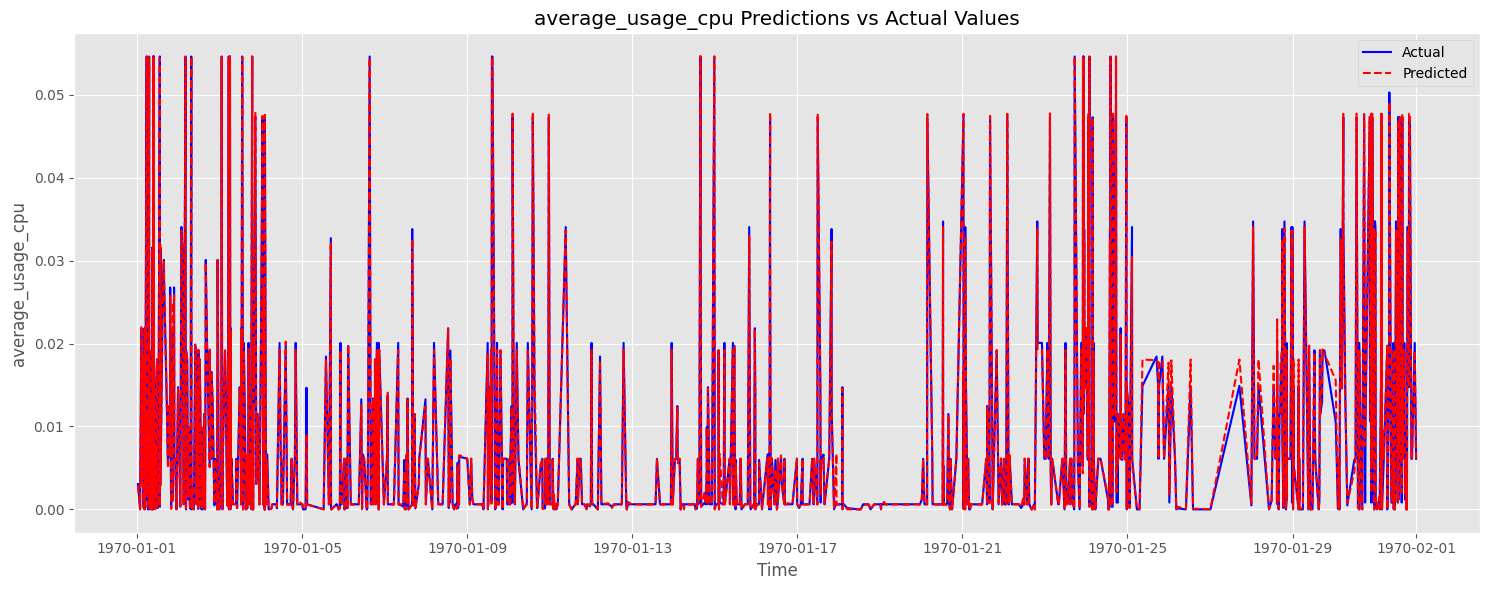

Prediction performance metrics:
RMSE: 0.001077
MAE: 0.000383
R²: 0.993453

Predicting future 240 time points for average_usage_cpu...
Average time interval: 0 days 00:03:27.244874274
Created dataframe with 240 future time points (minute precision)
Average historical change: 0.000000, std: 0.017477
Daily pattern detected with variation 0.1436
Weekly pattern detected with variation 0.2832
Model expects 36 features
Predicting time point 1/240: 1970-02-01 00:07:00
Predicting time point 2/240: 1970-02-01 00:10:00
Predicting time point 3/240: 1970-02-01 00:14:00
Predicting time point 4/240: 1970-02-01 00:17:00
Predicting time point 5/240: 1970-02-01 00:21:00
Predicting time point 6/240: 1970-02-01 00:24:00
Predicting time point 7/240: 1970-02-01 00:28:00
Predicting time point 8/240: 1970-02-01 00:31:00
Predicting time point 9/240: 1970-02-01 00:35:00
Predicting time point 10/240: 1970-02-01 00:38:00
Predicting time point 11/240: 1970-02-01 00:41:00
Predicting time point 12/240: 1970-02-01 00

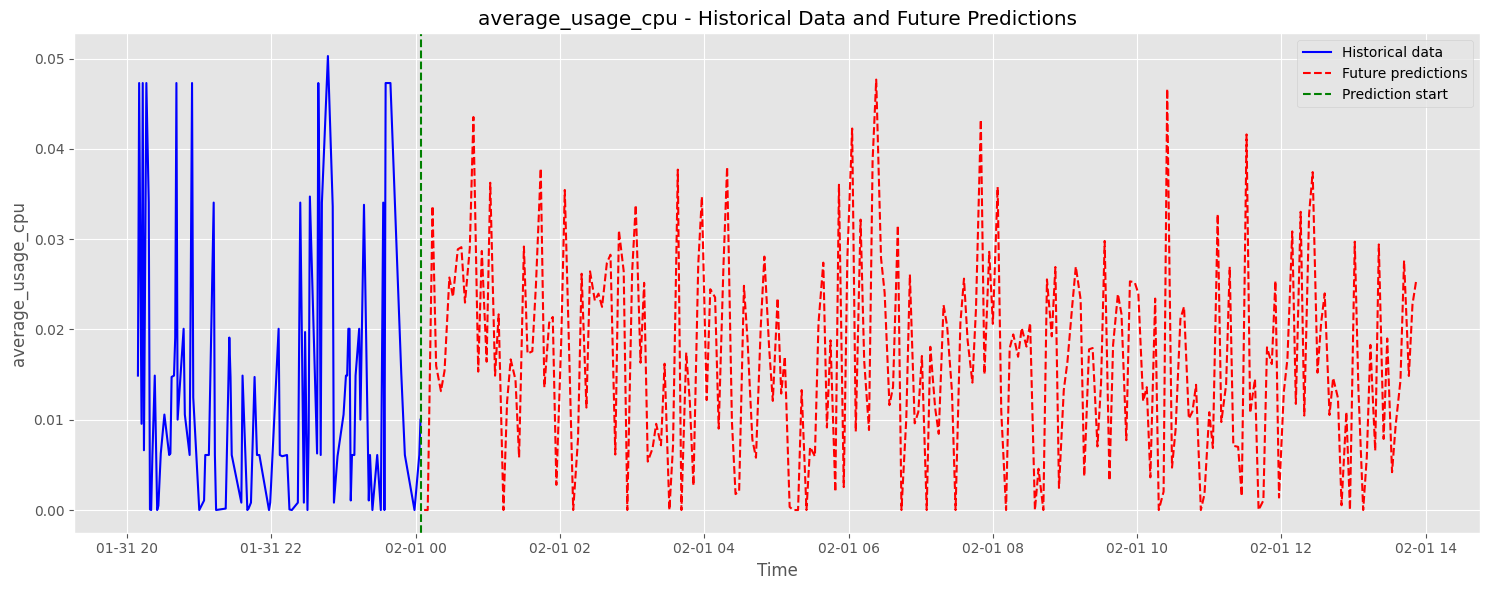

Future predictions saved to ../prediction_results/average_usage_cpu-xgb-user_DrrEIEW-future_predictions.csv

Processing target variable: average_usage_memory
Loaded model: ../models/xgb_memory_model.pkl
Loaded feature scaler: ../models/xgb_memory_scaler.pkl

Making predictions for average_usage_memory using the loaded model...
Model expects 36 features
  - hour (type: object)
Generated 12926 predictions
Too many data points, randomly sampling 1000 points for visualization


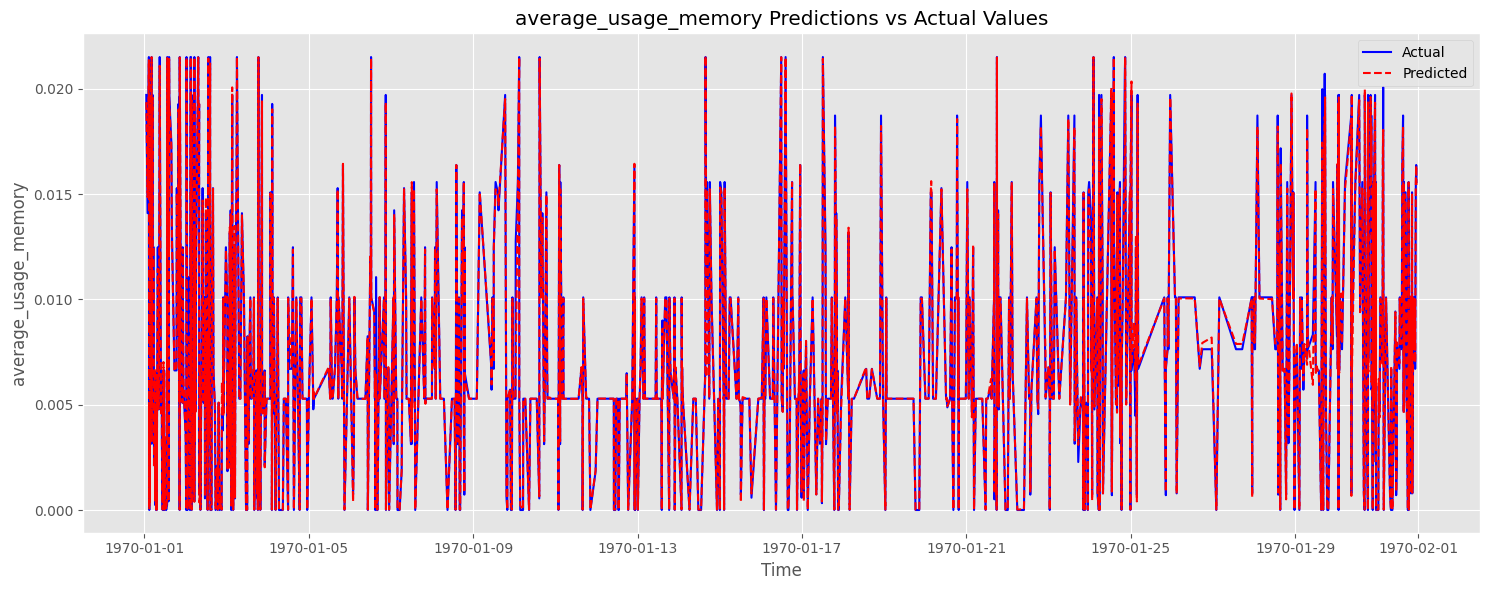

Prediction performance metrics:
RMSE: 0.000502
MAE: 0.000183
R²: 0.992178

Predicting future 240 time points for average_usage_memory...
Average time interval: 0 days 00:03:27.244874274
Created dataframe with 240 future time points (minute precision)
Average historical change: 0.000000, std: 0.007726
Daily pattern detected with variation 0.0819
Weekly pattern detected with variation 0.1148
Model expects 36 features
Predicting time point 1/240: 1970-02-01 00:07:00
Predicting time point 2/240: 1970-02-01 00:10:00
Predicting time point 3/240: 1970-02-01 00:14:00
Predicting time point 4/240: 1970-02-01 00:17:00
Predicting time point 5/240: 1970-02-01 00:21:00
Predicting time point 6/240: 1970-02-01 00:24:00
Predicting time point 7/240: 1970-02-01 00:28:00
Predicting time point 8/240: 1970-02-01 00:31:00
Predicting time point 9/240: 1970-02-01 00:35:00
Predicting time point 10/240: 1970-02-01 00:38:00
Predicting time point 11/240: 1970-02-01 00:41:00
Predicting time point 12/240: 1970-02-01

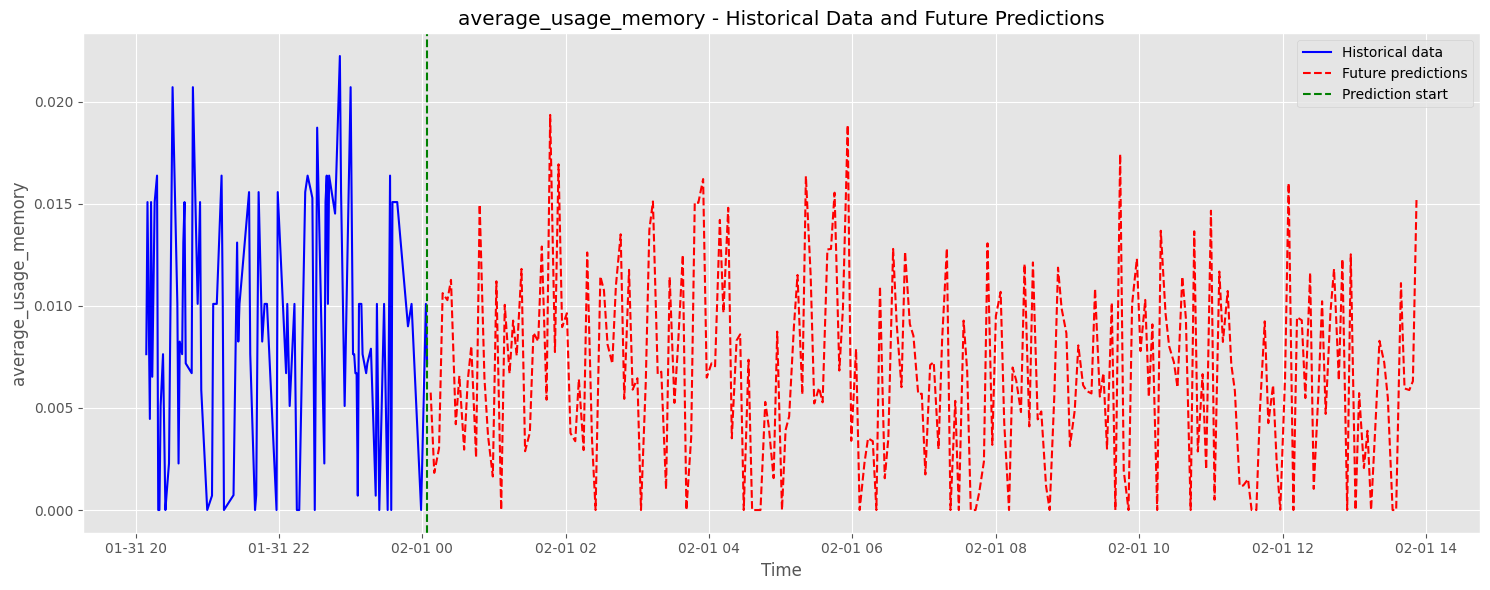

Future predictions saved to ../prediction_results/average_usage_memory-xgb-user_DrrEIEW-future_predictions.csv


In [195]:
# Check command line arguments
    # Default data path
data_path = '../processed_data/c7_user_DrrEIEW_timeseries.csv'

print(f"Reading data file: {data_path}")

# Read data
df = pd.read_csv(data_path)
print(f"Successfully read data, shape: {df.shape}")

# Process time features if present
if 'time_dt' in df.columns:
    df['time_dt'] = pd.to_datetime(df['time_dt']).dt.floor('min')
    print("Processed time_dt column to minute precision")

# Check if user information exists
user_columns = [col for col in df.columns if col == 'user' or col == 'user_id' or col.startswith('user_')]
if user_columns:
    print(f"Found user information columns: {', '.join(user_columns)}")
    # Check for unique user values
    for col in user_columns:
        unique_values = df[col].unique()
        if len(unique_values) == 1:
            print(f"  {col}: {unique_values[0]}")
        else:
            print(f"  {col}: {len(unique_values)} unique values")

# Check if target variables exist
target_vars = ['average_usage_cpu', 'average_usage_memory']
available_targets = [var for var in target_vars if var in df.columns]

if not available_targets:
    print("Error: No target variables found in the data")

# For each available target variable
for target_var in available_targets:
    print(f"\n{'='*50}")
    print(f"Processing target variable: {target_var}")
    print(f"{'='*50}")
    
    # Filter out rows with NaN in target variable
    df_clean = df.dropna(subset=[target_var])
    
    # 1. Make predictions on existing data
    model, scaler = load_model(target_var)
    if model is None or scaler is None:
        continue
        
    df_with_preds, _ = make_predictions(model, scaler, df_clean, target_var)
    
    # Visualize predictions
    visualize_predictions(df_with_preds, target_var, clean_user_id(df_clean['user'].iloc[0]))
    
    # 2. Make future predictions
    future_periods = 240  # Predict 24 time points ahead
    
    # Create time features and lag features for the historical data
    if 'time_dt' in df_clean.columns:
        df_features = create_time_features(df_clean, 'time_dt')
        df_features = create_lag_features(df_features, target_var)
        df_features = create_rolling_features(df_features, target_var)
        
        # Predict future values
        future_df, future_preds = predict_future_values(
            model, scaler, df_features, future_periods, target_var
        )
        
        if future_df is not None:
            # Make sure time_dt is floored to minute precision
            if 'time_dt' in future_df.columns:
                future_df['time_dt'] = pd.to_datetime(future_df['time_dt']).dt.floor('min')
                    
            # Visualize future predictions
            visualize_future_predictions(df_features, future_df, target_var, clean_user_id(future_df['user'].iloc[0]))
            
            # Save predictions
            output_dir = '../prediction_results'
            
            # Add user ID to filename if available in the data
            if 'user' in future_df.columns:
                user_id = clean_user_id(str(future_df['user'].iloc[0]))
                output_filename = f"{target_var}-xgb-user_{user_id}-future_predictions.csv"
            elif 'user_id' in future_df.columns:
                user_id = clean_user_id(str(future_df['user_id'].iloc[0]))
                output_filename = f"{target_var}-xgb-user_{user_id}-future_predictions.csv"
            else:
                # Use filename to extract user if possible
                try:
                    filename = os.path.basename(data_path)
                    if 'user_' in filename:
                        user_id = filename.split('user_')[1].split('_')[0]
                        output_filename = f"{target_var}-xgb-user_{user_id}-future_predictions.csv"
                    else:
                        output_filename = f"{target_var}-xgb-future_predictions.csv"
                except:
                    output_filename = f"{target_var}-xgb-future_predictions.csv"
            
            future_df.to_csv(os.path.join(output_dir, output_filename), index=False)
            print(f"Future predictions saved to {output_dir}/{output_filename}")
    else:
        print("Error: Time column 'time_dt' not found, cannot make future predictions")
